In [15]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

## Problem 1

In [2]:
ein=1.74
new=ein/2
edd=1.61
d_edd=0.4
cro=1.98
d_cro=0.16

evidence_edd_ein=norm(edd,d_edd).pdf(ein)
evidence_edd_new=norm(edd,d_edd).pdf(new)
evidence_cro_ein=norm(cro,d_cro).pdf(ein)
evidence_cro_new=norm(cro,d_cro).pdf(new)

b_edd=evidence_edd_ein/evidence_edd_new
b_cro=evidence_cro_ein/evidence_cro_new

print('Bayes Factor of GR w.r.t Newtonian Gravity, in the case of:')
print('Eddington Data=',b_edd)
print('Crommelin Data=',b_cro)
print('Finally, B=',b_edd*b_cro, ' in favour of GR')

Bayes Factor of GR w.r.t Newtonian Gravity, in the case of:
Eddington Data= 5.25109958796716
Crommelin Data= 9172292802.960836
Finally, B= 48164622958.3418  in favour of GR


From Jeffrey's Scale, Eddington's data shows substantial support for GR and Crommelin's data shows very decisive support for GR. All in all, GR is strongly supported.

## Problem 2

In [3]:
data=np.loadtxt('linefit.txt')
x=data[:,0][4:]
y=data[:,1][4:]
dy=data[:,2][4:]

In [4]:
def line(theta,x):
    return theta[0]*x+theta[1]

In [5]:
def log_prior(theta):
    
    #I'm setting uniform priors from - to +infty    
    
    return 0.0


def log_likelihood(theta, x,y,dy):
    
    yM=line(theta,x)    
    
    #I'll use a simple log likelihood function incorporating errors in y
    
    return -0.5 * (np.sum(2*np.pi*dy**2)+np.sum(((y - yM)/dy) ** 2))

def log_posterior(theta, x,y,dy):
    
    lp=log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,x,y,dy)

In [6]:
nwalkers=50
nsteps=2000
p1=np.random.uniform(-5,5,50)
p2=np.random.uniform(-20,20,50)
p0=np.vstack((p1,p2)).T
data=(x,y,dy)

In [7]:
def main(p0,nwalkers,nsteps,ndim,log_posterior,data):
    
    sampler=emcee.EnsembleSampler(nwalkers,ndim,log_posterior,args=data)
    print('Running burn-in...')
    pos,_,_=sampler.run_mcmc(p0,1000,progress=True)
    sampler=sampler.reset()
   
    sampler=emcee.EnsembleSampler(nwalkers,ndim,log_posterior,args=data)
    print('Running production...')
    pos,prob,state=sampler.run_mcmc(pos,nsteps,progress=True)
    return sampler,pos,prob,state

In [8]:
sampler,pos,prob,state = main(p0,nwalkers,nsteps,2,log_posterior,data)

Running burn-in...


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1166.64it/s]


Running production...


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1119.47it/s]


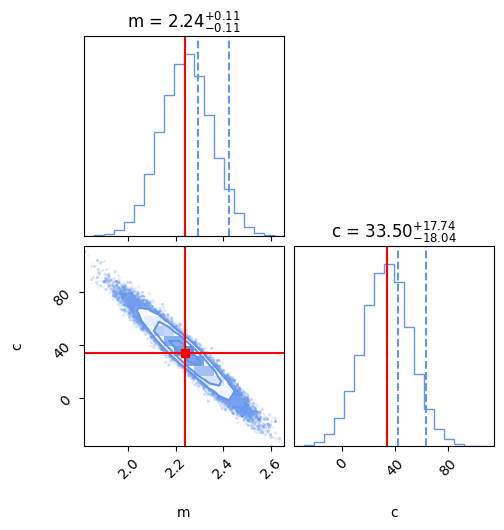

In [10]:
###### samples=sampler.flatchain
labels=['m','c']
theta_max=samples[np.argmax(sampler.flatlnprobability)]
best_fit_model=line(theta_max,x)
fig = corner.corner(samples,labels=labels,plot_datapoints=True,show_titles=True, use_math_text=True,truths=theta_max,color='cornflowerblue',truth_color='red',quantiles=[0.68,0.95])

## Problem 3

In [10]:
data=np.loadtxt('linefit.txt')
x=data[:,0]
y=data[:,1]
dy=data[:,2]

In [11]:
def squared_err(theta, x=x, y=y, dy=dy):
    err = y - theta[0]*x - theta[1]
    return np.sum(0.5 * (err / dy) ** 2)

theta1 = optimize.fmin(squared_err, [0, 0], disp=False)
theta1

array([  1.07674722, 213.27354938])

In [73]:
def log_prior(theta):
    
    # We want the values of g to be between 0 and 1.
    
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  

def log_likelihood(theta, x, y, e, sigma_B):
    
    '''
    There is one Gaussian likelihood corresponding to the actual data and another to represent the outliers.
    We use the parameter g, a multiplying factor for the Gaussian to demarcate the outliers from legitimate
    datapoints. The background gaussian dominates for low values of g or lower values of g correspond to outliers.
    '''
    
    dy = y - theta[1] - theta[0] * x
    g = np.clip(theta[2:], 0, 1)  
    
    # g<0 or g>1 leads to NaNs in logarithm
    
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

In [86]:
ndim = 2 + len(x)  
nwalkers = 50  
nburn = 10000  
nsteps = 25000 

p0 = np.zeros((nwalkers, ndim))

#Initialise starting guesses like Gaussian Priors about the MLE Estimate for the first two parameters.
p0[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
p0[:, 2:] = np.random.normal(0.4, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy, 70])
sampler.run_mcmc(p0, nsteps)

 
#Remove the burn-in samples. 
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/tmp/ipykernel_6918/3497496167.py:17: RuntimeWarning: divide by zero encountered in log
  logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
/tmp/ipykernel_6918/3497496167.py:18: RuntimeWarning: divide by zero encountered in log
  logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2


In [87]:
values=[]
for i in range(20):
    k=sample[:, i].mean()
    values.append(k)
    print(k)

1.0253245090282848
236.1729215677581
0.46740849139723584
0.36872370801693843
0.39134021819144776
0.3418805389525293
0.37888541617623694
0.35597107892862473
0.5489260473884026
0.36489936376260756
0.4138170790492947
0.5091423610420696
0.5678097827261029
0.5581383276125111
0.5148617784614532
0.34938006177848707
0.5497261493107637
0.41342157457336487
0.5614191994124621
0.45117390842196253


(array([1., 1., 0., 1., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 1.]),
 array([0.34188054, 0.34639912, 0.35091771, 0.35543629, 0.35995488,
        0.36447346, 0.36899205, 0.37351063, 0.37802922, 0.3825478 ,
        0.38706639, 0.39158497, 0.39610356, 0.40062214, 0.40514073,
        0.40965931, 0.4141779 , 0.41869648, 0.42321507, 0.42773365,
        0.43225224, 0.43677082, 0.44128941, 0.44580799, 0.45032658,
        0.45484516, 0.45936375, 0.46388233, 0.46840092, 0.4729195 ,
        0.47743809, 0.48195667, 0.48647525, 0.49099384, 0.49551242,
        0.50003101, 0.50454959, 0.50906818, 0.51358676, 0.51810535,
        0.52262393, 0.52714252, 0.5316611 , 0.53617969, 0.54069827,
        0.54521686, 0.54973544, 0.55425403, 0.55877261, 0.5632912 ,
        0.56780978]),
 <BarContainer object of 50 artists>)

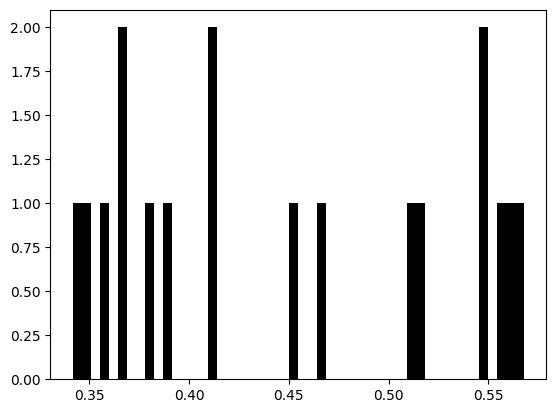

In [88]:
values=np.array(values)
w=np.where(values<1)
values=values[w]
plt.hist(values,bins=50,color='black')

Based on the above values I'm choosing g=0.40 as the cutoff for calling a point an outlier.

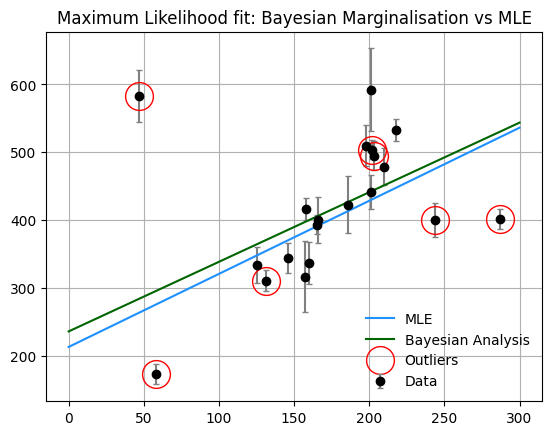

In [89]:
theta2 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.40)

xfit=np.linspace(0,300)
plt.errorbar(x, y, dy, fmt='o', ecolor='gray',capsize=2, color='black',label='Data')
plt.plot(xfit, theta1[1] + theta1[0] * xfit, color='dodgerblue',label='MLE')
plt.plot(xfit, theta2[1] + theta2[0] * xfit, color='darkgreen',label='Bayesian Analysis')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red',label='Outliers')
plt.legend(frameon=False)
plt.grid()
plt.title('Maximum Likelihood fit: Bayesian Marginalisation vs MLE');